# LightFM quick start with Movielens 100k dataset

### Comment

Two unexpected features:
- Train and Test division in a rather non-homogeneous way for movielens dataset leaving to a variation on performance
- The comparison for one example considers 3 examples on train, wich excludes many possibilities for comparison
- Learning rate schedules: what if we wanted to see the loss curve. Is precision_at_k and auc equivalent?

In [47]:
# Using MAC or Windows will give you the following warning
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k,auc_score

In [38]:
# Load the movielens 100k dataset. Only
# five star ratings are treated as positive.
data = fetch_movielens(min_rating = 0)
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [39]:
x = data['train']==5
x.data

array([ True,  True,  True, ...,  True,  True,  True])

In [40]:
for value in (data['train']==5).data:
    if value != True:
        print('lol')

- WARP (Weighted Approximate-Rank Pairwise) model ~ optimizes precision_at_k
- BPR: Bayesian Personalised Ranking pairwise loss ~ optimizes ROC AUC

Model training is accomplished via SGD (stochastic gradient descent)

In [41]:
# Instantiate and train the model
model = LightFM(loss= 'warp')
# epochs is the number of passings through data
%time model.fit(data['train'], epochs=60, num_threads=4)

# Evaluate the trained model
print("Train precision: %.2f" % precision_at_k(model, data['train'], k=10).mean())
print("Test precision: %.2f" % precision_at_k(model, data['test'],data['train'], k=10).mean())
print()
#recall_at_k
print("Train recall: %.2f" % recall_at_k(model, data['train'], k=10).mean())
print("Test recall: %.2f" % recall_at_k(model, data['test'],data['train'], k=10).mean())
print()
#auc_score
print("Train auc_score: %.2f" % auc_score(model, data['train']).mean())
print("Test auc_score: %.2f" % auc_score(model, data['test'],data['train']).mean())

CPU times: user 8.3 s, sys: 0 ns, total: 8.3 s
Wall time: 2.08 s
Train precision: 0.65
Test precision: 0.24

Train recall: 0.14
Test recall: 0.24

Train auc_score: 0.95
Test auc_score: 0.94


In [42]:
# Instantiate and train the model
model = LightFM(loss= 'bpr')
# epochs is the number of passings through data
%time model.fit(data['train'], epochs=60, num_threads=4)

# Evaluate the trained model
print("Train precision: %.2f" % precision_at_k(model, data['train'], k=10).mean())
print("Test precision: %.2f" % precision_at_k(model, data['test'],data['train'], k=10).mean())
print()
#recall_at_k
print("Train recall: %.2f" % recall_at_k(model, data['train'], k=10).mean())
print("Test recall: %.2f" % recall_at_k(model, data['test'],data['train'], k=10).mean())
print()
#auc_score
print("Train auc_score: %.2f" % auc_score(model, data['train']).mean())
print("Test auc_score: %.2f" % auc_score(model, data['test'],data['train']).mean())

CPU times: user 7.77 s, sys: 0 ns, total: 7.77 s
Wall time: 1.95 s
Train precision: 0.62
Test precision: 0.18

Train recall: 0.12
Test recall: 0.18

Train auc_score: 0.92
Test auc_score: 0.89


In [43]:
def sample_recommendation(model, data, user_ids):


    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:10]:
            print("        %s" % x)
            
        print("     %s" % (len([t for t in top_items[:10] if t in known_positives])/10) )

sample_recommendation(model, data, [0])

User 0
     Known positives:
        Toy Story (1995)
        GoldenEye (1995)
        Four Rooms (1995)
     Recommended:
        Star Wars (1977)
        Pulp Fiction (1994)
        Raiders of the Lost Ark (1981)
        Monty Python and the Holy Grail (1974)
        Silence of the Lambs, The (1991)
        Twelve Monkeys (1995)
        Raising Arizona (1987)
        Fish Called Wanda, A (1988)
        Willy Wonka and the Chocolate Factory (1971)
        Fargo (1996)
     1.0


In [44]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 90570 stored elements in COOrdinate format>

In [45]:
import numpy as np
19048*np.float32(5).nbytes

76192

In [46]:
type(data['train'])

scipy.sparse.coo.coo_matrix

### Learning Schedules

In [49]:
movielens = fetch_movielens()
train, test = movielens['train'], movielens['test']

In [78]:
%%time

alpha = 1e-3 # l2 regularization parameter
epochs = 70

adagrad_model = LightFM(no_components = 30,
                       loss = 'warp',
                        learning_schedule = 'adagrad',
                       user_alpha = alpha,
                       item_alpha = alpha)

adadelta_model = LightFM(no_components = 30,
                       loss = 'warp',
                        learning_schedule = 'adadelta',
                         user_alpha = alpha,
                       item_alpha = alpha)
adagrad_auc = []
adagrad_pk = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1, num_threads=4)
    adagrad_auc.append(auc_score(adagrad_model,test).mean())
    adagrad_pk.append(precision_at_k(adagrad_model,test,k=10).mean())

adadelta_auc = []
adadelta_pk = []
for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1, num_threads=4)
    adadelta_auc.append(auc_score(adadelta_model,test).mean())
    adadelta_pk.append(precision_at_k(adadelta_model,test,k=10).mean())

CPU times: user 1min 17s, sys: 27.1 ms, total: 1min 17s
Wall time: 45.4 s


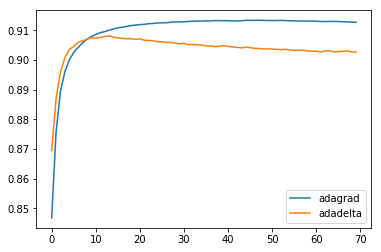

In [76]:
x= np.arange(len(adagrad_auc))
plt.plot(x,np.array(adagrad_auc))
plt.plot(x,np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc = 'lower right')
plt.show()

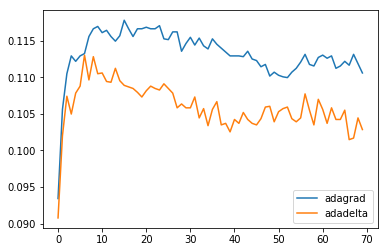

In [79]:
x= np.arange(len(adagrad_pk))
plt.plot(x,np.array(adagrad_pk))
plt.plot(x,np.array(adadelta_pk))
plt.legend(['adagrad', 'adadelta'], loc = 'lower right')
plt.show()

### Item cold-start